In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# --- Constants and Parameters ---
RHO_AIR = 1.2      # Density of air (kg/m³)
CP_AIR = 1005      # Specific heat capacity of air (J/kg°C)
G_CO2_PERSON = 5e-6 # CO₂ generation rate per person (m³/s) - converted 0.005 l/s
HEAT_PER_PERSON = 100 # Sensible heat gain per person (W)

# --- Building/Room Parameters 
ROOM_VOLUME = 150  # Volume of the simulated space (m³)
U_VOL = 0.135      # Volumetric heat loss coefficient (W/m³°C)
HEATING_CAPACITY = 3000 # Max heating power available (W)

# --- Thermal Mass Parameter ---
THERMAL_MASS_FACTOR = 15
C_EFFECTIVE = THERMAL_MASS_FACTOR * RHO_AIR * ROOM_VOLUME * CP_AIR # (J/°C)

# --- PID Control Parameters ---
KP_HEATING = 2500.0 # Proportional gain (W/°C)
KI_HEATING = 50.0   # Integral gain (W/(°C*s))
KD_HEATING = 10000.0 # Derivative gain (W*s/°C)
KP_VENT = 0.01     # Proportional gain (ACH/ppm)
KI_VENT = 0.0001   # Integral gain (ACH/(ppm*s))
KD_VENT = 0.0      # Derivative gain (ACH*s/ppm)
CO2_TARGET_PID = 900 # Target CO2 level (ppm) for PID control in S3/S4

# --- Ventilation Fan Parameters ---
SFP = 1500 # W/(m³/s)

# --- Simulation Parameters ---
SIMULATION_DURATION = 7 * 24 * 3600  # Simulate for 7 days (seconds)
DT = 60                            # Time step (seconds) - 1 minute
N_STEPS = SIMULATION_DURATION // DT

# --- Environmental Parameters ---
T_OUTDOOR_AVG = -1     # Average Outdoor temperature (°C)
COUT_PPM = 420        # Outdoor CO₂ concentration (ppm)
SIMULATION_START_DATE = pd.Timestamp("2025-02-20 00:00:00", tz='Europe/Helsinki')

# --- Scenario Specific Parameters ---
# Scenario 1
ACH_PASSIVE = 1
ETA_PASSIVE = 0.0
T_SETPOINT_CONST = 22

# Scenario 2
ACH_MECH = 1.3
ETA_MECH = 0.7

# Scenario 3
ACH_DCV_MIN = 0.3
ACH_DCV_MAX = 1.8
ETA_DCV = 0.7

# Scenario 4
T_SETPOINT_OCCUPIED = 22
T_SETPOINT_UNOCCUPIED = 18

# --- Pre-heat Parameter ---
PREHEAT_DURATION_SECONDS = 3600 # 1 hour

# --- Carbon Emission Factors ---
CF_DH = 0.072          # District Heating: kgCO₂/kWh
CF_EL = 0.032          # Electricity: kgCO₂/kWh

# --- Occupancy Schedule Parameters ---
OCCUPANCY_START_HOUR = 8
OCCUPANCY_END_HOUR = 17
WEEKEND_DAYS = [5, 6] # Monday=0, Saturday=5, Sunday=6
MIN_OCCUPANTS = 4
MAX_OCCUPANTS = 12
OCCUPANCY_CHANGE_INTERVAL_MIN = 30 # Check every 30 minutes

In [ ]:
# --- Helper Functions ---

def load_real_temp_data(filepath, sim_start_date, sim_duration_s, dt_s):
    try:
        df = pd.read_csv(filepath, decimal=',', parse_dates=['time'])
        df = df.dropna(subset=['time', 'temp'])
        df['temp'] = pd.to_numeric(df['temp'], errors='coerce')
        df = df.dropna(subset=['temp']).set_index('time').sort_index()

        sim_end = sim_start_date + pd.Timedelta(seconds=sim_duration_s)
        sim_index = pd.date_range(sim_start_date, sim_end, freq=f'{dt_s}S', tz=sim_start_date.tz)

        temp = df['temp'].reindex(sim_index).interpolate('time').bfill().ffill()
        if temp.isnull().all():
            print("Warning: No valid data after processing.")
            return None

        print(f"Temperature data loaded from {temp.index[0]} to {temp.index[-1]}")
        return temp
    except Exception as e:
        print(f"Error loading temperature data: {e}")
        return None

def get_outdoor_temp(t, real_temp_series, sim_start_date, base_temp=T_OUTDOOR_AVG):
    if real_temp_series is not None:
        time = sim_start_date + pd.Timedelta(seconds=t)
        try:
            return real_temp_series.get(time, base_temp)
        except:
            return base_temp
    return simulate_outdoor_temp(t, base_temp)

def simulate_outdoor_temp(t, base_temp):
    """ Original function to simulate daily temperature fluctuation. """
    amplitude = 4
    seconds_in_day = 24 * 3600
    time_of_day_seconds = t % seconds_in_day
    return base_temp - amplitude * np.cos(2 * np.pi * (time_of_day_seconds - 4*3600) / seconds_in_day)


# --- occupancy generator ---
def generate_realistic_occupancy(duration_s, dt_s, start_hour, end_hour, min_occ, max_occ,
                                 change_interval_min, weekend_days):
    n_steps = duration_s // dt_s
    times = np.arange(0, duration_s, dt_s)
    occupancy_profile = np.zeros(n_steps)
    current_occupancy = 0
    change_interval_s = change_interval_min * 60
    last_change_check_time = -change_interval_s
    for i in range(n_steps):
        t = times[i]
        seconds_in_day = 24 * 3600
        day_of_week = int(t // seconds_in_day) % 7
        hour = int(t // 3600) % 24
        is_weekend = day_of_week in weekend_days
        is_work_hour = start_hour <= hour < end_hour
        if t >= last_change_check_time + change_interval_s:
            last_change_check_time = t
            if not is_weekend and is_work_hour:
                change = random.choice([-1, 0, 0, 1])
                new_occupancy = current_occupancy + change
                current_occupancy = max(min_occ, min(max_occ, new_occupancy))
            elif not is_work_hour:
                 current_occupancy = 0
        occupancy_profile[i] = current_occupancy if not is_weekend else 0
    return occupancy_profile

# --- Predictive setpoint function ---
def get_predictive_dynamic_setpoint(t, occupied_setpoint, unoccupied_setpoint,
                                   start_hour=OCCUPANCY_START_HOUR, end_hour=OCCUPANCY_END_HOUR,
                                   preheat_seconds=PREHEAT_DURATION_SECONDS):
    """ Returns the target temperature based on potential occupancy (work hours), including pre-heat, and considers weekends. Assumes t=0 is the start of Monday. """
    seconds_in_day = 24 * 3600
    day_of_week = int(t // seconds_in_day) % 7
    if day_of_week in WEEKEND_DAYS: 
        return unoccupied_setpoint
    time_of_day_seconds = t % seconds_in_day
    occupancy_start_seconds = start_hour * 3600; occupancy_end_seconds = end_hour * 3600
    preheat_start_seconds = occupancy_start_seconds - preheat_seconds
    if preheat_start_seconds < 0: 
        preheat_start_seconds += seconds_in_day
    current_setpoint = unoccupied_setpoint
    if occupancy_start_seconds <= time_of_day_seconds < occupancy_end_seconds: 
        current_setpoint = occupied_setpoint
    elif preheat_start_seconds < occupancy_start_seconds:
        if preheat_start_seconds <= time_of_day_seconds < occupancy_start_seconds: 
            current_setpoint = occupied_setpoint
    else:
         if time_of_day_seconds >= preheat_start_seconds: 
            current_setpoint = occupied_setpoint
    return current_setpoint

# --- Core Theoritical Model Functions ---
def calculate_conduction_loss(T_indoor, T_outdoor, V, U_vol): 
    """5.5.3 Conduction Losses"""
    return U_vol * V * max(0, T_indoor - T_outdoor)

def calculate_ventilation_loss(T_indoor, T_outdoor, V, ach, rho, cp, eta):
    """5.5.2 Ventilation Losses"""
    ach_per_sec = ach / 3600.0; 
    airflow_rate = V * ach_per_sec
    return rho * cp * airflow_rate * (1 - eta) * max(0, T_indoor - T_outdoor)

def calculate_internal_gain(n_occupants, heat_per_person): 
    """5.4 Building Occupancy and its impact on indoor air quality and heating"""
    return n_occupants * heat_per_person

def update_co2_concentration(C_current, Cout, n, G, V, ach, dt):
    """5.4 Building Occupancy and its impact on indoor air quality and heating"""
    ach_per_sec = ach / 3600.0; 
    k = ach_per_sec; 
    G_ppm_per_sec = (n * G * 1e6) / V
    exp_term = np.exp(-k * dt)
    steady_state = Cout + G_ppm_per_sec / k
    C_new = steady_state + (C_current - steady_state) * exp_term
    return max(Cout, C_new)

def update_indoor_temperature(T_current, Q_heat_applied, Q_internal, Q_cond_loss, Q_vent_loss, C_effective, dt):
    """5.5.4 Combined heat loss and indoor temperature dynamics"""
    Q_net = Q_heat_applied + Q_internal - Q_cond_loss - Q_vent_loss
    dT = (Q_net / C_effective) * dt; 
    T_new = T_current + dT
    return T_new

# --- Simulation Loop ---

def run_simulation(scenario_name, V, U_vol,
                   real_temp_series, # Pass the loaded temp data
                   occupancy_profile,
                   ach_mode, base_ach, eta, T_setpoint_func,
                   pid_heat_params, pid_vent_params,
                   dcv_limits=None,
                   initial_T=18, initial_C=COUT_PPM,
                   heating_capacity=HEATING_CAPACITY, c_effective=C_EFFECTIVE,
                   sfp=SFP, cf_dh=CF_DH, cf_el=CF_EL,
                   sim_start_date=SIMULATION_START_DATE): # Pass start date for lookup
    """ Runs the simulation for a given scenario with PID control, using real temp data if available. """

    print(f"--- Running Simulation: {scenario_name} ---")
    kp_h, ki_h, kd_h = pid_heat_params['kp'], pid_heat_params['ki'], pid_heat_params['kd']
    kp_v, ki_v, kd_v, co2_target = pid_vent_params['kp'], pid_vent_params['ki'], pid_vent_params['kd'], pid_vent_params['target']

    times = np.arange(0, SIMULATION_DURATION, DT)
    if len(occupancy_profile) != N_STEPS:
        raise ValueError(f"Occupancy profile length ({len(occupancy_profile)}) does not match N_STEPS ({N_STEPS})")

    temps = np.zeros(N_STEPS); 
    co2_levels = np.zeros(N_STEPS)
    heating_power = np.zeros(N_STEPS); 
    fan_power_ts = np.zeros(N_STEPS)
    ach_actual = np.zeros(N_STEPS); 
    T_setpoints_actual = np.zeros(N_STEPS)
    T_outdoor_actual = np.zeros(N_STEPS)

    temps[0] = initial_T; co2_levels[0] = initial_C
    T_setpoints_actual[0] = T_setpoint_func(0)
    T_outdoor_actual[0] = get_outdoor_temp(0, real_temp_series, sim_start_date) # Get initial outdoor temp
    integral_temp_error = 0.0; prev_temp_error = 0.0
    integral_co2_error = 0.0; prev_co2_error = 0.0

    if ach_mode == 'passive' or ach_mode == 'mechanical': current_ach = base_ach
    elif ach_mode == 'dcv_pid': current_ach = dcv_limits['ach_min']
    else: current_ach = 0.5
    ach_actual[0] = current_ach

    total_heating_energy_kwh = 0.0; total_fan_energy_kwh = 0.0

    for i in range(1, N_STEPS):
        t = times[i]
        T_in_prev = temps[i-1]; C_in_prev = co2_levels[i-1]
        T_out = get_outdoor_temp(t, real_temp_series, sim_start_date)
        T_outdoor_actual[i] = T_out # Store the temp used
        # ---
        n_occupants = int(occupancy_profile[i])
        T_setpoint = T_setpoint_func(t); T_setpoints_actual[i] = T_setpoint

        # Ventilation Control (PID logic)
        if ach_mode == 'passive' or ach_mode == 'mechanical': current_ach = base_ach
        elif ach_mode == 'dcv_pid':
            co2_error = C_in_prev - co2_target
            if not ((current_ach <= dcv_limits['ach_min'] and co2_error < 0) or \
                    (current_ach >= dcv_limits['ach_max'] and co2_error > 0)):
                 integral_co2_error += co2_error * DT
            derivative_co2_error = (co2_error - prev_co2_error) / DT if DT > 0 else 0.0
            pid_ach_output = (kp_v * co2_error) + (ki_v * integral_co2_error) + (kd_v * derivative_co2_error)
            current_ach = max(dcv_limits['ach_min'], min(dcv_limits['ach_max'], pid_ach_output))
            prev_co2_error = co2_error
        ach_actual[i] = current_ach

        # Heat loss and gains 
        Q_cond = calculate_conduction_loss(T_in_prev, T_out, V, U_vol)
        Q_vent = calculate_ventilation_loss(T_in_prev, T_out, V, current_ach, RHO_AIR, CP_AIR, eta)
        Q_int = calculate_internal_gain(n_occupants, HEAT_PER_PERSON)

        # Heating PID Control
        temp_error = T_setpoint - T_in_prev
        prev_heat_applied = heating_power[i-1]
        if not ((prev_heat_applied <= 0 and temp_error < 0) or \
                (prev_heat_applied >= heating_capacity and temp_error > 0)):
            integral_temp_error += temp_error * DT
        derivative_temp_error = (temp_error - prev_temp_error) / DT if DT > 0 else 0.0
        pid_heat_output = (kp_h * temp_error) + (ki_h * integral_temp_error) + (kd_h * derivative_temp_error)
        heat_applied = max(0, min(heating_capacity, pid_heat_output))
        heating_power[i] = heat_applied
        prev_temp_error = temp_error

        # Fan Power Calculation
        fan_power = 0
        if ach_mode == 'mechanical' or ach_mode == 'dcv_pid':
             ach_per_sec = current_ach / 3600.0; airflow_rate_m3s = V * ach_per_sec
             fan_power = sfp * airflow_rate_m3s
        fan_power_ts[i] = fan_power

        # Update state variables
        temps[i] = update_indoor_temperature(T_in_prev, heat_applied, Q_int, Q_cond, Q_vent, c_effective, DT)
        co2_levels[i] = update_co2_concentration(C_in_prev, COUT_PPM, n_occupants, G_CO2_PERSON, V, current_ach, DT)

        # Accumulate energy
        total_heating_energy_kwh += (heat_applied * DT) / (3600 * 1000)
        total_fan_energy_kwh += (fan_power * DT) / (3600 * 1000)

    # Final calculations
    total_heating_emissions_kg = total_heating_energy_kwh * cf_dh
    total_electricity_emissions_kg = total_fan_energy_kwh * cf_el
    total_energy_kwh = total_heating_energy_kwh + total_fan_energy_kwh
    total_emissions_kg = total_heating_emissions_kg + total_electricity_emissions_kg

    num_days = SIMULATION_DURATION / (24 * 3600)
    print(f"Total Heating Energy ({num_days:.0f} days): {total_heating_energy_kwh:.2f} kWh")
    print(f"Total Fan Energy ({num_days:.0f} days): {total_fan_energy_kwh:.2f} kWh")
    print(f"Total Heating Emissions (DH) ({num_days:.0f} days): {total_heating_emissions_kg:.2f} kg CO₂")
    print(f"Total Electricity Emissions (Fan) ({num_days:.0f} days): {total_electricity_emissions_kg:.2f} kg CO₂")
    print(f"Total Emissions (Combined) ({num_days:.0f} days): {total_emissions_kg:.2f} kg CO₂")
    print("-"*(len(scenario_name) + 28))

    results = pd.DataFrame({
        'Time (s)': times, 'T_Indoor (°C)': temps, 'CO2 (ppm)': co2_levels,
        'Heating Power (W)': heating_power, 'Fan Power (W)': fan_power_ts,

        'T_Outdoor (°C)': T_outdoor_actual,
        'Occupants': occupancy_profile,
        'ACH_Actual': ach_actual, 'T_Setpoint (°C)': T_setpoints_actual
    })

    return results, total_heating_energy_kwh, total_heating_emissions_kg, \
           total_fan_energy_kwh, total_electricity_emissions_kg, \
           total_energy_kwh, total_emissions_kg

Generating realistic occupancy profile...
Occupancy profile generated.
Loading real temperature data from temp20feb26feb.csv...
Temperature data loaded from 2025-02-20 00:00:00+02:00 to 2025-02-27 00:00:00+02:00
--- Running Simulation: S1_Passive_PIDHeat ---


C:\Users\muzah\AppData\Local\Temp\ipykernel_22864\1830896060.py:11: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  sim_index = pd.date_range(sim_start_date, sim_end, freq=f'{dt_s}S', tz=sim_start_date.tz)


Total Heating Energy (7 days): 220.26 kWh
Total Fan Energy (7 days): 0.00 kWh
Total Heating Emissions (DH) (7 days): 15.86 kg CO₂
Total Electricity Emissions (Fan) (7 days): 0.00 kg CO₂
Total Emissions (Combined) (7 days): 15.86 kg CO₂
----------------------------------------------
--- Running Simulation: S2_Mech_HRV_PIDHeat ---
Total Heating Energy (7 days): 115.13 kWh
Total Fan Energy (7 days): 13.65 kWh
Total Heating Emissions (DH) (7 days): 8.29 kg CO₂
Total Electricity Emissions (Fan) (7 days): 0.44 kg CO₂
Total Emissions (Combined) (7 days): 8.73 kg CO₂
-----------------------------------------------
--- Running Simulation: S3_DCV_PID ---
Total Heating Energy (7 days): 74.44 kWh
Total Fan Energy (7 days): 5.41 kWh
Total Heating Emissions (DH) (7 days): 5.36 kg CO₂
Total Electricity Emissions (Fan) (7 days): 0.17 kg CO₂
Total Emissions (Combined) (7 days): 5.53 kg CO₂
--------------------------------------
--- Running Simulation: S4_DCV_PID_Predictive ---
Total Heating Energy (7 d

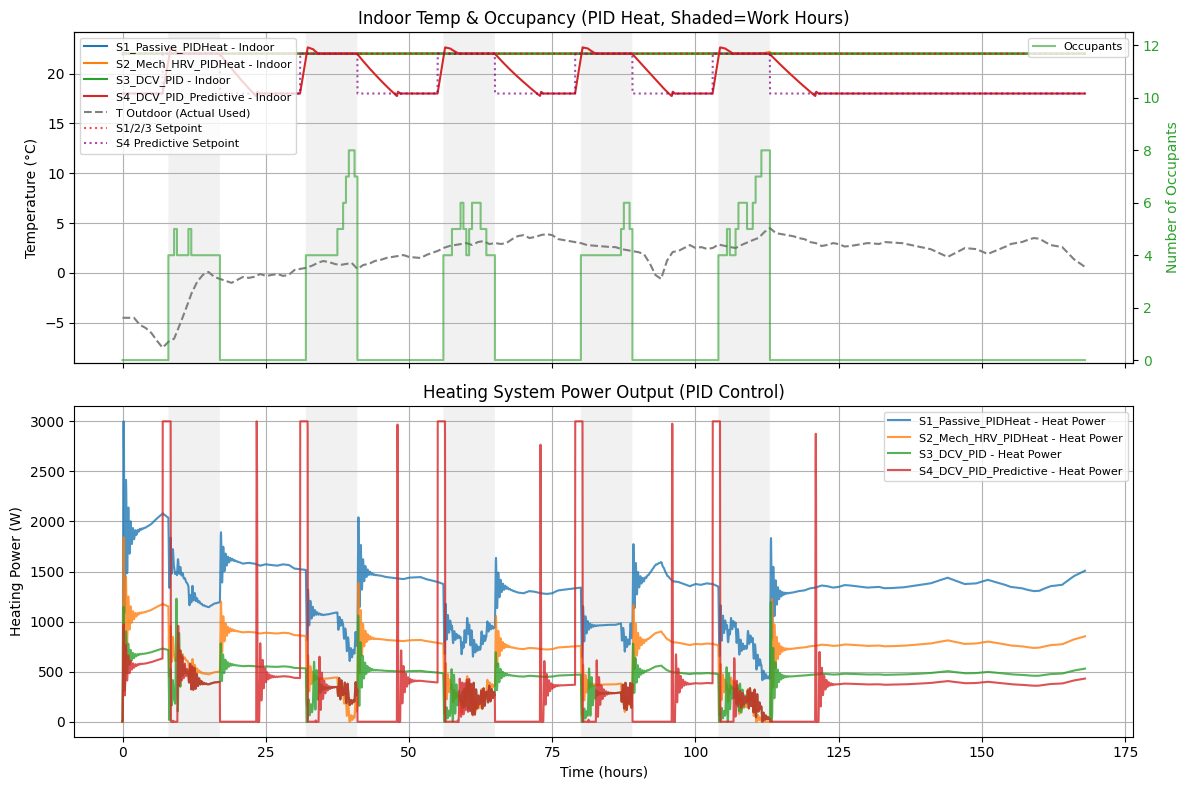

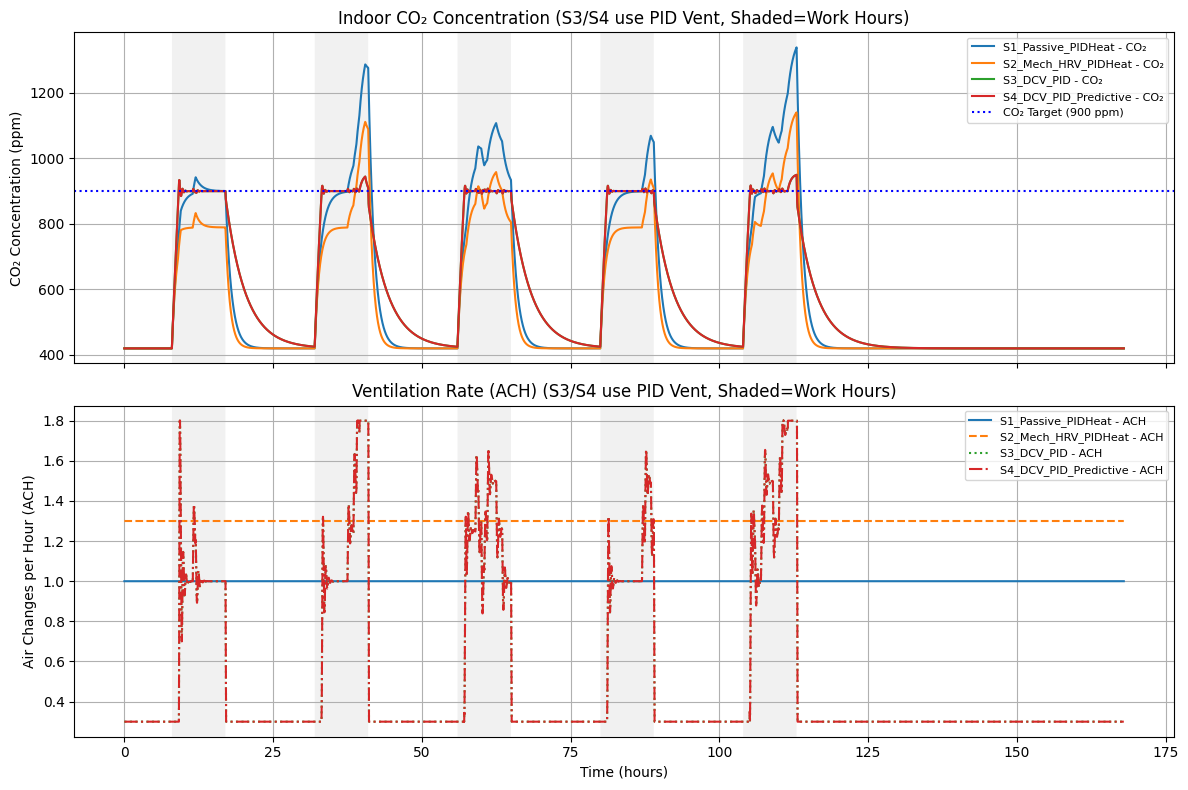


--- Simulation Summary Metrics (7 days) ---
                       Heating kWh (7d)  Fan kWh (7d)  Total kWh (7d)  \
Scenario                                                                
S1_Passive_PIDHeat               220.26          0.00          220.26   
S2_Mech_HRV_PIDHeat              115.13         13.65          128.78   
S3_DCV_PID                        74.44          5.41           79.84   
S4_DCV_PID_Predictive             64.15          5.41           69.55   

                       Heating CO2 kg (7d)  Fan CO2 kg (7d)  \
Scenario                                                      
S1_Passive_PIDHeat                   15.86             0.00   
S2_Mech_HRV_PIDHeat                   8.29             0.44   
S3_DCV_PID                            5.36             0.17   
S4_DCV_PID_Predictive                 4.62             0.17   

                       Total CO2 kg (7d)  Avg CO2 Occ (ppm)  Max CO2 (ppm)  \
Scenario                                                   

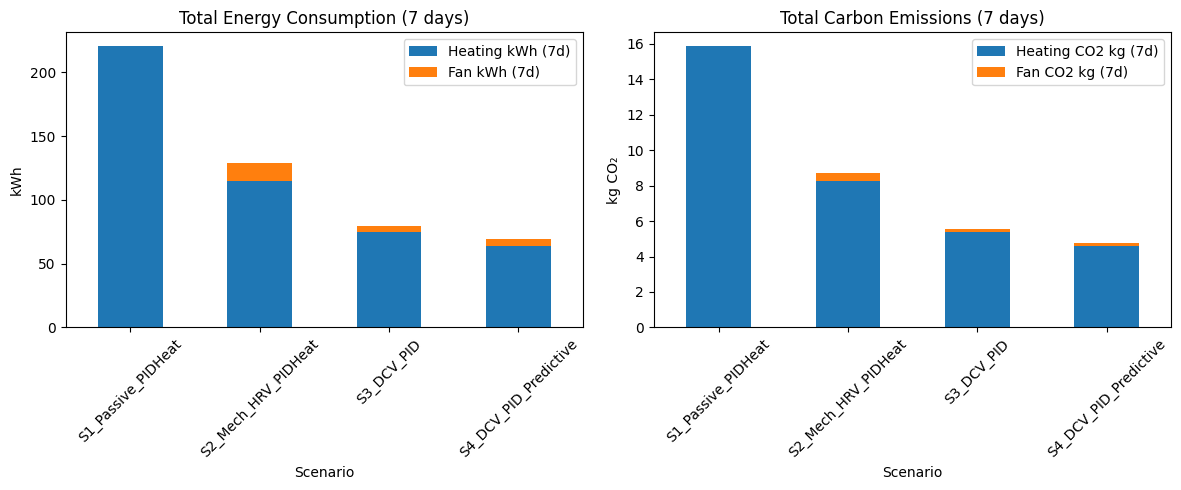

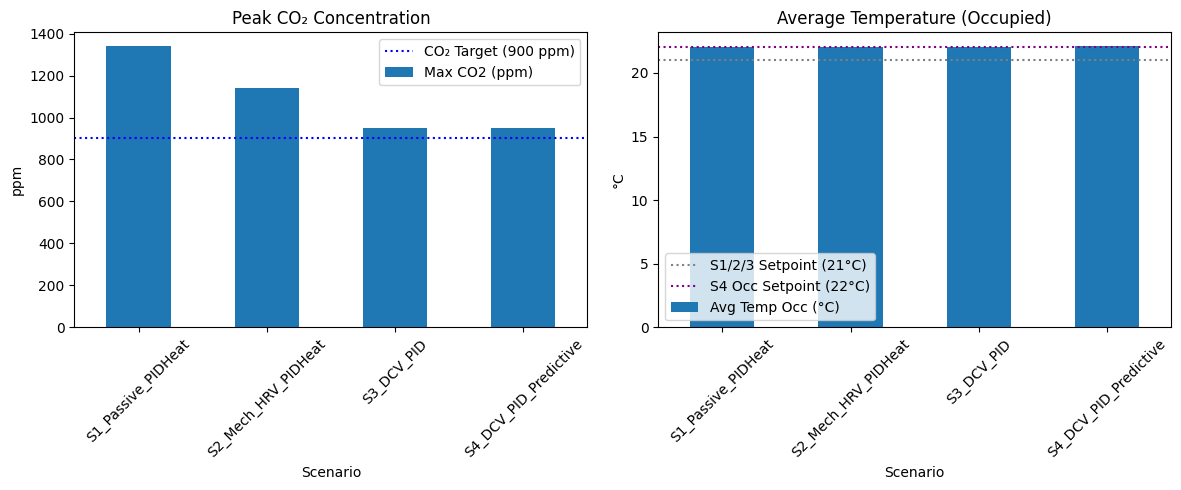

In [ ]:
# --- Define PID Parameter Dictionaries ---
pid_heat_params = {'kp': KP_HEATING, 'ki': KI_HEATING, 'kd': KD_HEATING}
pid_vent_params = {'kp': KP_VENT, 'ki': KI_VENT, 'kd': KD_VENT, 'target': CO2_TARGET_PID}
dcv_limits_params = {'ach_min': ACH_DCV_MIN, 'ach_max': ACH_DCV_MAX}

# --- Generate Occupancy Profile ONCE ---
print("Generating realistic occupancy profile...")
occupancy_profile_realistic = generate_realistic_occupancy(
    SIMULATION_DURATION, DT, OCCUPANCY_START_HOUR, OCCUPANCY_END_HOUR, MIN_OCCUPANTS,
    MAX_OCCUPANTS, OCCUPANCY_CHANGE_INTERVAL_MIN, WEEKEND_DAYS
)
print("Occupancy profile generated.")

# --- Load Real Temperature Data ONCE ---
real_temp_file = 'temp20feb26feb.csv'
print(f"Loading real temperature data from {real_temp_file}...")
real_temp_data_series = load_real_temp_data(real_temp_file, SIMULATION_START_DATE, SIMULATION_DURATION, DT)


# --- Run Scenarios ---
results_all = {}
metrics = {}
scenario_keys = ['S1', 'S2', 'S3', 'S4']
for key in scenario_keys: metrics[key] = {}

# Scenario 1
T_setpoint_scen1 = lambda t: T_SETPOINT_CONST
res, heat_kwh, heat_co2, fan_kwh, fan_co2, total_kwh, total_co2 = run_simulation(
    "S1_Passive_PIDHeat", ROOM_VOLUME, U_VOL,
    real_temp_data_series,
    occupancy_profile_realistic,
    'passive', ACH_PASSIVE, ETA_PASSIVE, T_setpoint_scen1,
    pid_heat_params=pid_heat_params, pid_vent_params=pid_vent_params,
    initial_T=T_SETPOINT_CONST
)
results_all['S1_Passive_PIDHeat'] = res
metrics['S1'].update({'Heat_kWh': heat_kwh, 'Heat_CO2': heat_co2, 'Fan_kWh': fan_kwh, 'Fan_CO2': fan_co2, 'Total_kWh': total_kwh, 'Total_CO2': total_co2})

# Scenario 2
T_setpoint_scen2 = lambda t: T_SETPOINT_CONST
res, heat_kwh, heat_co2, fan_kwh, fan_co2, total_kwh, total_co2 = run_simulation(
    "S2_Mech_HRV_PIDHeat", ROOM_VOLUME, U_VOL,
    real_temp_data_series,
    occupancy_profile_realistic,
    'mechanical', ACH_MECH, ETA_MECH, T_setpoint_scen2,
    pid_heat_params=pid_heat_params, pid_vent_params=pid_vent_params,
    initial_T=T_SETPOINT_CONST
)
results_all['S2_Mech_HRV_PIDHeat'] = res
metrics['S2'].update({'Heat_kWh': heat_kwh, 'Heat_CO2': heat_co2, 'Fan_kWh': fan_kwh, 'Fan_CO2': fan_co2, 'Total_kWh': total_kwh, 'Total_CO2': total_co2})

# Scenario 3
T_setpoint_scen3 = lambda t: T_SETPOINT_CONST
res, heat_kwh, heat_co2, fan_kwh, fan_co2, total_kwh, total_co2 = run_simulation(
    "S3_DCV_PID", ROOM_VOLUME, U_VOL,
    real_temp_data_series,
    occupancy_profile_realistic,
    'dcv_pid', -1, ETA_DCV, T_setpoint_scen3,
    pid_heat_params=pid_heat_params, pid_vent_params=pid_vent_params,
    dcv_limits=dcv_limits_params,
    initial_T=T_SETPOINT_CONST
)
results_all['S3_DCV_PID'] = res
metrics['S3'].update({'Heat_kWh': heat_kwh, 'Heat_CO2': heat_co2, 'Fan_kWh': fan_kwh, 'Fan_CO2': fan_co2, 'Total_kWh': total_kwh, 'Total_CO2': total_co2})

# Scenario 4
T_setpoint_scen4_predictive_weekend = lambda t: get_predictive_dynamic_setpoint(
    t, T_SETPOINT_OCCUPIED, T_SETPOINT_UNOCCUPIED,
    start_hour=OCCUPANCY_START_HOUR, end_hour=OCCUPANCY_END_HOUR,
    preheat_seconds=PREHEAT_DURATION_SECONDS
)
res, heat_kwh, heat_co2, fan_kwh, fan_co2, total_kwh, total_co2 = run_simulation(
    "S4_DCV_PID_Predictive", ROOM_VOLUME, U_VOL,
    real_temp_data_series,
    occupancy_profile_realistic,
    'dcv_pid', -1, ETA_DCV, T_setpoint_scen4_predictive_weekend,
    pid_heat_params=pid_heat_params, pid_vent_params=pid_vent_params,
    dcv_limits=dcv_limits_params,
    initial_T=T_SETPOINT_UNOCCUPIED
)
results_all['S4_DCV_PID_Predictive'] = res
metrics['S4'].update({'Heat_kWh': heat_kwh, 'Heat_CO2': heat_co2, 'Fan_kWh': fan_kwh, 'Fan_CO2': fan_co2, 'Total_kWh': total_kwh, 'Total_CO2': total_co2})


# --- Plotting Results (Plots show 7 days) ---
# Figure 1: Temperature and Heating
fig1, axes1 = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Temperature Plot (axes1[0])
ax_temp = axes1[0]
for name, df in results_all.items(): ax_temp.plot(df['Time (s)'] / 3600, df['T_Indoor (°C)'], label=f'{name} - Indoor')
# --- Plot actual outdoor temp used in simulation ---
ax_temp.plot(results_all['S1_Passive_PIDHeat']['Time (s)'] / 3600, results_all['S1_Passive_PIDHeat']['T_Outdoor (°C)'], label='T Outdoor (Actual Used)', linestyle='--', color='grey')
# ---
ax_temp.plot(results_all['S1_Passive_PIDHeat']['Time (s)'] / 3600, results_all['S1_Passive_PIDHeat']['T_Setpoint (°C)'], label='S1/2/3 Setpoint', linestyle=':', color='red', alpha=0.7)
ax_temp.plot(results_all['S4_DCV_PID_Predictive']['Time (s)'] / 3600, results_all['S4_DCV_PID_Predictive']['T_Setpoint (°C)'], label='S4 Predictive Setpoint', linestyle=':', color='purple', alpha=0.7)
ax_temp.set_ylabel('Temperature (°C)', color='black'); ax_temp.tick_params(axis='y', labelcolor='black'); ax_temp.grid(True)
ax_temp.set_title('Indoor Temp & Occupancy (PID Heat, Shaded=Work Hours)')

# Secondary Axis for Occupancy
ax_occ = ax_temp.twinx()
time_hours = results_all['S1_Passive_PIDHeat']['Time (s)'] / 3600
occupancy_data = occupancy_profile_realistic # Plot the generated profile
ax_occ.plot(time_hours, occupancy_data, label='Occupants', color='tab:green', linestyle='-', alpha=0.6, drawstyle='steps-post')
ax_occ.set_ylabel('Number of Occupants', color='tab:green'); ax_occ.tick_params(axis='y', labelcolor='tab:green')
ax_occ.set_ylim(bottom=-0.1, top=MAX_OCCUPANTS + 0.5)

# Combine legends
lines_temp, labels_temp = ax_temp.get_legend_handles_labels()
lines_occ, labels_occ = ax_occ.get_legend_handles_labels()
ax_temp.legend(lines_temp, labels_temp, loc='upper left', fontsize=8)
ax_occ.legend(lines_occ, labels_occ, loc='upper right', fontsize=8)

# Shading for potential occupied period (Work Hours)
work_hours_schedule = np.zeros(N_STEPS)
times_for_shading = np.arange(0, SIMULATION_DURATION, DT)
for i in range(N_STEPS):
    t_shade = times_for_shading[i]
    day_of_week_shade = int(t_shade // (24*3600)) % 7
    hour_shade = int(t_shade // 3600) % 24
    if day_of_week_shade not in WEEKEND_DAYS and OCCUPANCY_START_HOUR <= hour_shade < OCCUPANCY_END_HOUR:
        work_hours_schedule[i] = 1

y_min_temp, y_max_temp = ax_temp.get_ylim()
ax_temp.fill_between(time_hours, y_min_temp, y_max_temp, where=work_hours_schedule > 0, facecolor='lightgrey', alpha=0.3, step='post')
ax_temp.set_ylim(y_min_temp, y_max_temp)

# Heating Power Plot (axes1[1])
ax_heat = axes1[1]
for name, df in results_all.items(): ax_heat.plot(df['Time (s)'] / 3600, df['Heating Power (W)'], label=f'{name} - Heat Power', alpha=0.8)
y_min_h, y_max_h = ax_heat.get_ylim()
ax_heat.fill_between(time_hours, y_min_h, y_max_h, where=work_hours_schedule > 0, facecolor='lightgrey', alpha=0.3, step='post')
ax_heat.set_ylim(y_min_h, y_max_h)
ax_heat.set_ylabel('Heating Power (W)'); ax_heat.set_xlabel('Time (hours)'); ax_heat.legend(fontsize=8, loc='best'); ax_heat.grid(True)
ax_heat.set_title('Heating System Power Output (PID Control)')

fig1.tight_layout(); plt.show()


# Figure 2: CO2 and Ventilation Rate
fig2, axes2 = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax = axes2[0]
for name, df in results_all.items(): ax.plot(df['Time (s)'] / 3600, df['CO2 (ppm)'], label=f'{name} - CO₂')
ax.axhline(CO2_TARGET_PID, color='blue', linestyle=':', label=f'CO₂ Target ({CO2_TARGET_PID} ppm)')
y_min_c, y_max_c = ax.get_ylim(); ax.fill_between(time_hours, y_min_c, y_max_c, where=work_hours_schedule > 0, facecolor='lightgrey', alpha=0.3, step='post'); ax.set_ylim(y_min_c, y_max_c)
ax.set_ylabel('CO₂ Concentration (ppm)'); ax.legend(fontsize=8, loc='best'); ax.grid(True); ax.set_title('Indoor CO₂ Concentration (S3/S4 use PID Vent, Shaded=Work Hours)')
ax = axes2[1]
linestyle_map = {'S1_Passive_PIDHeat': '-', 'S2_Mech_HRV_PIDHeat': '--', 'S3_DCV_PID': ':', 'S4_DCV_PID_Predictive': '-.'}
for name, df in results_all.items():
     if name in linestyle_map:
         style = linestyle_map[name]
         ax.plot(df['Time (s)'] / 3600, df['ACH_Actual'], label=f'{name} - ACH', linestyle=style, linewidth=1.5)
y_min_a, y_max_a = ax.get_ylim(); ax.fill_between(time_hours, y_min_a, y_max_a, where=work_hours_schedule > 0, facecolor='lightgrey', alpha=0.3, step='post'); ax.set_ylim(y_min_a, y_max_a)
ax.set_ylabel('Air Changes per Hour (ACH)'); ax.set_xlabel('Time (hours)'); ax.legend(fontsize=8, loc='best'); ax.grid(True); ax.set_title('Ventilation Rate (ACH) (S3/S4 use PID Vent, Shaded=Work Hours)')
fig2.tight_layout(); plt.show()


# --- Summary Metrics (Calculates totals over 7 days) ---
num_days_summary = SIMULATION_DURATION / (24 * 3600)
print(f"\n--- Simulation Summary Metrics ({num_days_summary:.0f} days) ---")
metrics_map = {'S1_Passive_PIDHeat': 'S1', 'S2_Mech_HRV_PIDHeat': 'S2', 'S3_DCV_PID': 'S3', 'S4_DCV_PID_Predictive': 'S4'}

# --- FIX: Convert lists to numpy arrays before multiplication ---
heat_kwh_list = np.array([metrics[metrics_map[name]]['Heat_kWh'] for name in results_all])
fan_kwh_list = np.array([metrics[metrics_map[name]]['Fan_kWh'] for name in results_all])
total_kwh_list = np.array([metrics[metrics_map[name]]['Total_kWh'] for name in results_all])

avg_co2_occ_list = []; avg_temp_occ_list = []
for name in results_all:
    df_occ = results_all[name][results_all[name]['Occupants'] > 0]
    avg_co2_occ_list.append(df_occ['CO2 (ppm)'].mean() if not df_occ.empty else 0)
    avg_temp_occ_list.append(df_occ['T_Indoor (°C)'].mean() if not df_occ.empty else results_all[name]['T_Indoor (°C)'].mean())
max_co2_list = [results_all[name]['CO2 (ppm)'].max() for name in results_all]

# Recalculate CO2 emissions based on totals and factors for consistency
recalc_heat_co2 = heat_kwh_list * CF_DH
recalc_fan_co2 = fan_kwh_list * CF_EL
recalc_total_co2 = recalc_heat_co2 + recalc_fan_co2

summary = pd.DataFrame({
    f'Heating kWh ({num_days_summary:.0f}d)': heat_kwh_list,
    f'Fan kWh ({num_days_summary:.0f}d)': fan_kwh_list,
    f'Total kWh ({num_days_summary:.0f}d)': total_kwh_list,
    f'Heating CO2 kg ({num_days_summary:.0f}d)': recalc_heat_co2,
    f'Fan CO2 kg ({num_days_summary:.0f}d)': recalc_fan_co2,
    f'Total CO2 kg ({num_days_summary:.0f}d)': recalc_total_co2,
    'Avg CO2 Occ (ppm)': avg_co2_occ_list,
    'Max CO2 (ppm)': max_co2_list,
    'Avg Temp Occ (°C)': avg_temp_occ_list
}, index=list(results_all.keys()))

summary.index.name = "Scenario"
print(summary.round(2))

# Summary Bar Charts (Shows totals over 7 days)
fig_metrics_1, axes_metrics_1 = plt.subplots(1, 2, figsize=(12, 5))
summary[[f'Heating kWh ({num_days_summary:.0f}d)', f'Fan kWh ({num_days_summary:.0f}d)']].plot(kind='bar', stacked=True, ax=axes_metrics_1[0])
axes_metrics_1[0].set_title(f'Total Energy Consumption ({num_days_summary:.0f} days)'); axes_metrics_1[0].set_ylabel('kWh'); axes_metrics_1[0].tick_params(axis='x', rotation=45)
summary[[f'Heating CO2 kg ({num_days_summary:.0f}d)', f'Fan CO2 kg ({num_days_summary:.0f}d)']].plot(kind='bar', stacked=True, ax=axes_metrics_1[1])
axes_metrics_1[1].set_title(f'Total Carbon Emissions ({num_days_summary:.0f} days)'); axes_metrics_1[1].set_ylabel('kg CO₂'); axes_metrics_1[1].tick_params(axis='x', rotation=45)
plt.tight_layout(); plt.show()

fig_metrics_2, axes_metrics_2 = plt.subplots(1, 2, figsize=(12, 5))
summary['Max CO2 (ppm)'].plot(kind='bar', ax=axes_metrics_2[0])
axes_metrics_2[0].set_title('Peak CO₂ Concentration'); axes_metrics_2[0].set_ylabel('ppm'); axes_metrics_2[0].tick_params(axis='x', rotation=45); axes_metrics_2[0].axhline(CO2_TARGET_PID, color='b', linestyle=':', label=f'CO₂ Target ({CO2_TARGET_PID} ppm)'); axes_metrics_2[0].legend()
T_SETPOINT_CONST_PLOT = 21; T_SETPOINT_OCCUPIED_PLOT = 22 # User example values
summary['Avg Temp Occ (°C)'].plot(kind='bar', ax=axes_metrics_2[1])
axes_metrics_2[1].set_title('Average Temperature (Occupied)'); axes_metrics_2[1].set_ylabel('°C'); axes_metrics_2[1].tick_params(axis='x', rotation=45); axes_metrics_2[1].axhline(T_SETPOINT_CONST_PLOT, color='grey', linestyle=':', label=f'S1/2/3 Setpoint ({T_SETPOINT_CONST_PLOT}°C)'); axes_metrics_2[1].axhline(T_SETPOINT_OCCUPIED_PLOT, color='purple', linestyle=':', label=f'S4 Occ Setpoint ({T_SETPOINT_OCCUPIED_PLOT}°C)'); axes_metrics_2[1].legend()
plt.tight_layout(); plt.show()